# Casino HMM: learning (parameter estimation)

We use a simple example of an HMM from known as the "occasionally dishonest casino".
This is from the book
"Biological Sequence Analysis: Probabilistic Models of Proteins and Nucleic Acids"
by R. Durbin, S. Eddy, A. Krogh and G. Mitchison (1998).

We sample data from the model, then fit the model to the data, using EM and SGD.


## Setup

In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax
dynamax.__file__

'/Users/kpmurphy/github/dynamax/dynamax/__init__.py'

In [8]:
try:
    import graphviz
except ModuleNotFoundError:
    %pip install graphviz

In [3]:

from functools import partial

import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import optax

from graphviz import Digraph
import matplotlib.pyplot as plt

from dynamax.hmm.models import CategoricalHMM
# from dynamax.hmm.demos.casino_hmm import make_model_and_data

In [6]:
def hmm_plot_graphviz(trans_mat, obs_mat, states=[], observations=[]):
    """
    Visualizes HMM transition matrix and observation matrix using graphhiz.
    Parameters
    ----------
    trans_mat, obs_mat, init_dist: arrays
    states: List(num_hidden)
        Names of hidden states
    observations: List(num_obs)
        Names of observable events
    Returns
    -------
    dot object, that can be displayed in colab
    """

    n_states, _, n_obs = obs_mat.shape

    dot = Digraph(comment="HMM")
    if not states:
        states = [f"State {i + 1}" for i in range(n_states)]
    if not observations:
        observations = [f"Obs {i + 1}" for i in range(n_obs)]

    # Creates hidden state nodes
    for i, name in enumerate(states):
        table = [f'<TR><TD>{observations[j]}</TD><TD>{"%.2f" % prob}</TD></TR>' for j, prob in enumerate(obs_mat[i,0])]
        label = f"""<<TABLE><TR><TD BGCOLOR="lightblue" COLSPAN="2">{name}</TD></TR>{''.join(table)}</TABLE>>"""
        dot.node(f"s{i}", label=label)

    # Writes transition probabilities
    for i in range(n_states):
        for j in range(n_states):
            dot.edge(f"s{i}", f"s{j}", label=str("%.2f" % trans_mat[i, j]))
    dot.attr(rankdir="LR")
    # dot.render(file_name, view=True)
    return dot

## Sample data from true model

In [ ]:
num_states = 2
num_emissions = 1
num_classes = 6
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

params = dict(
    initial=dict(probs=jnp.array([1, 1]) / 2),
    transitions=dict(transition_matrix=jnp.array([[0.95, 0.05], [0.10, 0.90]])),
    emissions=dict(probs=jnp.array(
        [
            [1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],  # fair die
            [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10],  # loaded die
        ]
    ).reshape(num_states, num_emissions, num_classes))
)

In [42]:

num_batches = 10
num_timesteps = 5000
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

batch_states, batch_emissions = \
    vmap(partial(hmm.sample, params, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(42), num_batches))

print(batch_states.shape) 
print(batch_emissions.shape)
print(batch_emissions.size)

(10, 5000)
(10, 5000, 1)
50000


In [43]:


def extract_params(params):
    A = params['transitions']['transition_matrix']
    B = params['emissions']['probs'] # (nstates, 1, noutputs)
    pi = params['initial']['probs']
    return pi, A, B[:, 0, :]

def print_floats(probs):
    str = ['{:.3f},'.format(p) for p in probs]
    print(str)

def print_params(params):
    pi, A, B = extract_params(params)
    print('initial dist: ');
    print_floats(pi)
    print('transition matrix')
    nstates = len(pi)
    for k in range(nstates):
        print_floats(A[k,:])
    print('emission matrix')
    for k in range(nstates):
        print_floats(B[k,:])

print_params(params)


initial dist: 
['0.500,', '0.500,']
transition matrix
['0.950,', '0.050,']
['0.100,', '0.900,']
emission matrix
['0.167,', '0.167,', '0.167,', '0.167,', '0.167,', '0.167,']
['0.100,', '0.100,', '0.100,', '0.100,', '0.100,', '0.500,']


In [12]:
#dotfile = hmm_plot_graphviz(params["transitions"]["transition_matrix"], params["emissions"]["probs"])
#dotfile.render("hmm-casino-true-dot")
#dotfile

## Learning

In [45]:
num_epochs = 400
learning_rate = 1e-2
momentum = 0.95
optimizer = optax.sgd(learning_rate=learning_rate, momentum=momentum)
shuffle = True

### Full-Batch Gradient Descent

In [46]:
key = jr.PRNGKey(1)
fbgd_params, fbgd_param_props = hmm.random_initialization(key)
fbgd_params, losses_fbgd = hmm.fit_sgd(fbgd_params, 
                                       fbgd_param_props, 
                                       batch_emissions, 
                                       optimizer=optimizer, 
                                       batch_size=num_batches, 
                                       num_epochs=num_epochs, 
                                       shuffle=shuffle, 
                                       key=key)

In [47]:

print_params(fbgd_params)

initial dist: 
['0.409,', '0.596,']
transition matrix
['0.371,', '0.629,']
['0.668,', '0.332,']
emission matrix
['0.211,', '0.066,', '0.097,', '0.162,', '0.173,', '0.291,']
['0.082,', '0.239,', '0.215,', '0.138,', '0.133,', '0.194,']


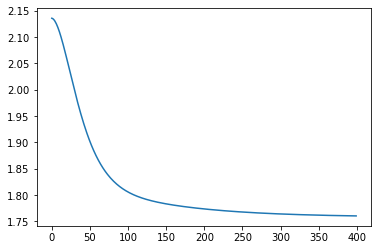

In [48]:
fig, ax = plt.subplots()
ax.plot(losses_fbgd)


### Mini-Batch Gradient Descent

In [49]:
key = jr.PRNGKey(1)
mbgd_params, mbgd_param_props = hmm.random_initialization(key)
mbgd_params, losses_mbgd = hmm.fit_sgd(mbgd_params, 
                                       mbgd_param_props, 
                                       batch_emissions, 
                                       optimizer=optimizer, 
                                       batch_size=2, 
                                       num_epochs=num_epochs, 
                                       shuffle=shuffle, 
                                       key=key)

In [50]:
print_params(mbgd_params)

initial dist: 
['0.416,', '0.609,']
transition matrix
['0.431,', '0.569,']
['0.628,', '0.372,']
emission matrix
['0.189,', '0.079,', '0.111,', '0.149,', '0.161,', '0.311,']
['0.093,', '0.217,', '0.190,', '0.139,', '0.133,', '0.226,']


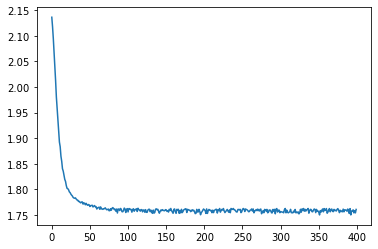

In [51]:
fig, ax = plt.subplots()
ax.plot(losses_mbgd)


### Expectation-Maximization

In [52]:
key = jr.PRNGKey(0)
em_params, em_param_props = hmm.random_initialization(key)

print('parameters before learning')
print_params(em_params)

em_params, log_liks = hmm.fit_em(em_params, 
                                  em_param_props, 
                                  batch_emissions, 
                                  num_iters=num_epochs)
losses_em = -log_liks / batch_emissions.size # divide by (num sequences * num time steps), so scale is comparable to sgd

print('parameters after learning')
print_params(em_params)

  0%|          | 0/400 [00:00<?, ?it/s]

parameters before learning
initial dist: 
['0.362,', '0.638,']
transition matrix
['0.033,', '0.967,']
['0.720,', '0.280,']
emission matrix
['0.001,', '0.016,', '0.105,', '0.087,', '0.424,', '0.367,']
['0.063,', '0.036,', '0.123,', '0.247,', '0.179,', '0.353,']


100%|██████████| 400/400 [00:02<00:00, 156.74it/s]

parameters after learning
initial dist: 
['0.712,', '0.288,']
transition matrix
['0.042,', '0.958,']
['0.546,', '0.454,']
emission matrix
['0.131,', '0.129,', '0.165,', '0.141,', '0.163,', '0.271,']
['0.151,', '0.155,', '0.140,', '0.145,', '0.138,', '0.271,']


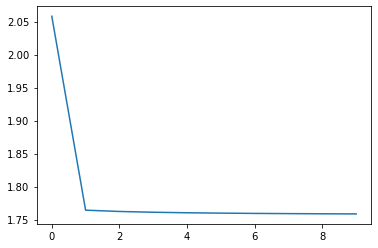

In [53]:
fig, ax = plt.subplots()
ax.plot(losses_em[:10])